# Exploratory Analysis of Import Data

This notebook explores the PIERS Bill of Lading data, obtained from S&P's Global Trade Analytics Suite. See the README.md file for more info on the overall project, data pre-processing, and column definitions. 

In [40]:
#import libraries
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
from plotly.subplots import make_subplots
import missingno as msno

#display settings
pd.set_option('display.max_columns', None)
%matplotlib inline

#enable string cache for polars categoricals
pl.enable_string_cache()

## Basic Data Summary

This sections presents basic summary statistics on each variable in the dataset. See the [discussion below regarding known issues with the dataset](#known-data-issues)

In [41]:
#create lazyframes, get shape and basic counts

#set paths
imports_path = 'data/clean/imports/'
exports_path = 'data/clean/exports/'

#get schema and col names
imports_schema = pl.read_parquet_schema(source= imports_path+'piers_imports_2005.parquet')
imports_colnames = imports_schema.keys()
exports_schema = pl.read_parquet_schema(source=exports_path+'piers_exports_complete.parquet')
exports_colnames = exports_schema.keys()

#init lazy dataframes
imports_lzdf = (
    pl.scan_parquet(imports_path+'*.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_arrival').dt.year().alias('year'),
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month')
        ])
    )
exports_lzdf = (
    pl.scan_parquet(exports_path+'piers_exports_complete.parquet', parallel='columns')
    .with_columns([
        #create 2-digit hs code
        pl.col('hs_code').str.slice(0, length=2).alias('hs_2d'),
        #create year and month columns
        pl.col('date_departure').dt.year().alias('year'),
        pl.col('date_departure').dt.strftime('%Y%m').alias('month')
        ])
    )

#get number of observations
imports_n = imports_lzdf.select(pl.count()).collect().item()
exports_n = exports_lzdf.select(pl.count()).collect().item()
print('The imports dataset has {:,} rows and {} columns.'.format(imports_n, len(imports_schema)))
print('The exports dataset has {:,} rows and {} columns.'.format(exports_n, len(exports_schema)))

The imports dataset has 178,875,896 rows and 44 columns.
The exports dataset has 68,769,489 rows and 31 columns.


In [42]:
#view head of imports dataframe
print('Imports dataframe preview:')
imports_lzdf.limit(n=3).collect()

Imports dataframe preview:


weight,weight_unit,qty,qty_type,teus,value_est,date_arrival,container_piece_count,commod_short_desc_qty,origin_territory,origin_region,arrival_port_code,arrival_port_name,departure_port_code,departure_port_name,dest_final,coast_region,clearing_district,place_receipt,shipper_name,shipper_address,consignee_name,consignee_address,notify_party1_name,notify_party1_address,notify_party2_name,notify_party2_address,commod_desc_raw,container_id_marks,marks_desc,hs_code,joc_code,commod_short_desc,container_ids,carrier_name,carrier_scac,vessel_name,voyage_id,precarrier,vessel_id,inbond_code,transport_mode,bol_number,bol_id,hs_2d,year,month
f64,cat,f64,cat,f64,f64,datetime[μs],i32,str,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,cat,cat,str,str,f64,i32,f64,cat,str,str,str,i32,str
0.0,"""KG""",19.0,"""PCS""",0.0,0.0,2005-12-15 00:00:00,1,"""19""","""SWEDEN""","""NORTH EUROPE""","""4601""","""NEW YORK""","""42879""","""HAMBURG""",""" ""","""EAST""",null,"""MALMO""","""ORDER""","""""","""ORDER""","""2258 ALLEN STR…","""ORDER""","""2258 ALLEN STR…",null,null,null,"""""","""LC""","""870899""","""""","""""","""PONU7791697""","""P&O NEDLLOYD""","""PONL""","""P&O NEDLLOYD Y…","""5449""",null,9252993,null,null,"""HBGSF10809""","""PONL_HBGSF1080…","""87""",2005,"""200512"""
0.0,"""KG""",329.0,"""CTN""",0.0,0.0,2005-10-12 00:00:00,1,"""329""","""CHINA (MAINLAN…","""NORTH EAST ASI…","""2709""","""LONG BEACH""","""57035""","""SHANGHAI""",""" ""","""WEST""","""LOS ANGELES, C…","""SHANGHAI""","""CARNIVAL""","""21F E 1 ZHENGH…","""ELEGANCE PRINT…","""YIP ST""","""GRAMTER INTERN…","""11222 S LA CIE…",null,null,null,"""""","""LC""","""852990""","""""","""""","""FSCU7037551""","""CHINA NATIONAL…","""CNFT""","""TRADE FOISON""","""35""",null,9158525,null,null,"""0509SGA017F""","""CNFT_0509SGA01…","""85""",2005,"""200510"""
0.0,"""KG""",14.0,"""CTN""",0.0,0.0,2005-08-29 00:00:00,1,"""14""","""SPAIN""","""MEDITERRANEAN""","""4601""","""NEW YORK""","""47061""","""BARCELONA""",""" ""","""EAST""",null,"""BARCELONA""","""EMPRESA TEXTIL…","""""","""ATHLETA""","""1450 TECHNOLOG…","""OZ ARCHITECTS""","""6621 N SCOTTSD…",null,null,null,"""""","""LC""","""620630""","""""","""""","""CCLU6360140""","""CHINA SHIPPING…","""CSCN""","""ZIM VIRGINIA""","""12""",null,9231808,null,null,"""BCNLE2687B""","""CSCN_BCNLE2687…","""62""",2005,"""200508"""


In [43]:
#view head of exports dataframe 
print('Exports dataframe preview:')
exports_lzdf.limit(n=3).collect()

Exports dataframe preview:


shipper,shipper_address,weight,weight_unit,qty,quantity_type,teus,carrier_name,carrier_scac,vessel_name,voyage_id,bol_number,vessel_id,value_est,departure_port_code,departure_port_name,container_ids,container_piece_count,coast_region,commod_desc_raw,commod_short_desc,hs_code,joc_code,commod_short_desc_qty,date_departure,origin,dest_territory,dest_region,dest_port_code_declared,dest_port_name,bol_id,hs_2d,year,month
str,str,f64,cat,f64,cat,f64,cat,cat,str,str,str,i32,f64,cat,cat,str,i32,cat,str,str,str,str,str,datetime[μs],str,cat,cat,cat,cat,str,str,i32,str
null,null,0.0,"""KG""",3.0,"""LOT""",0.0,"""P&O NEDLLOYD""","""PONL""","""SOPHIA BRITANN…","""7888""","""CLNAM5446568""",9030723,0.0,"""1703""","""SAVANNAH""","""PONU4744937 PO…",4,"""EAST""",null,"""""","""0207""","""""","""1; 1; 1; 1""",2005-04-01 00:00:00,""" ""","""ITALY""","""MEDITERRANEAN""","""47536""","""GIOIA TAURO""","""PONL_CLNAM5446…","""02""",2005,"""200504"""
null,null,0.0,"""KG""",6.0,"""SKD""",0.0,"""COMPANIA CHILE…","""CCNI""","""CSAV HAMBURGO""","""62""","""USNYC13578""",9138276,0.0,"""4601""","""NEW YORK""","""""",0,"""EAST""",null,"""""","""901890""","""""","""6""",2005-12-07 00:00:00,""" ""","""CHILE""","""WEST COAST SOU…","""33779""","""SAN ANTONIO""","""CCNI_USNYC1357…","""90""",2005,"""200512"""
null,null,0.0,"""KG""",7.0,"""PCS""",0.0,"""UNAVAILABLE ON…","""ZZZZ""","""WATER SPIRIT""","""144""","""WS022477""",8119950,0.0,"""4909""","""SAN JUAN""","""""",0,"""CARIBBEAN""",null,"""""","""5407""","""""","""7""",2005-10-27 00:00:00,""" ""","""VIRGIN ISLAND""","""CARIBBEAN""","""91115""","""CHRISTIANSTED""","""ZZZZ_WS022477""","""54""",2005,"""200510"""


### Missing Data

The data from S&P have few missing values; however, some volume metrics such as TEUs and Weight have many zero-valued BOLs. Current info from S&P indicates this should not be happening, and we are pursuing solutions. 

Missing Values Matrix for Exports. 
The vertical axis corresponds to date, with earliest at the top.  
Note the daily aggregation counts the row as non-null if any value that day is non-null.


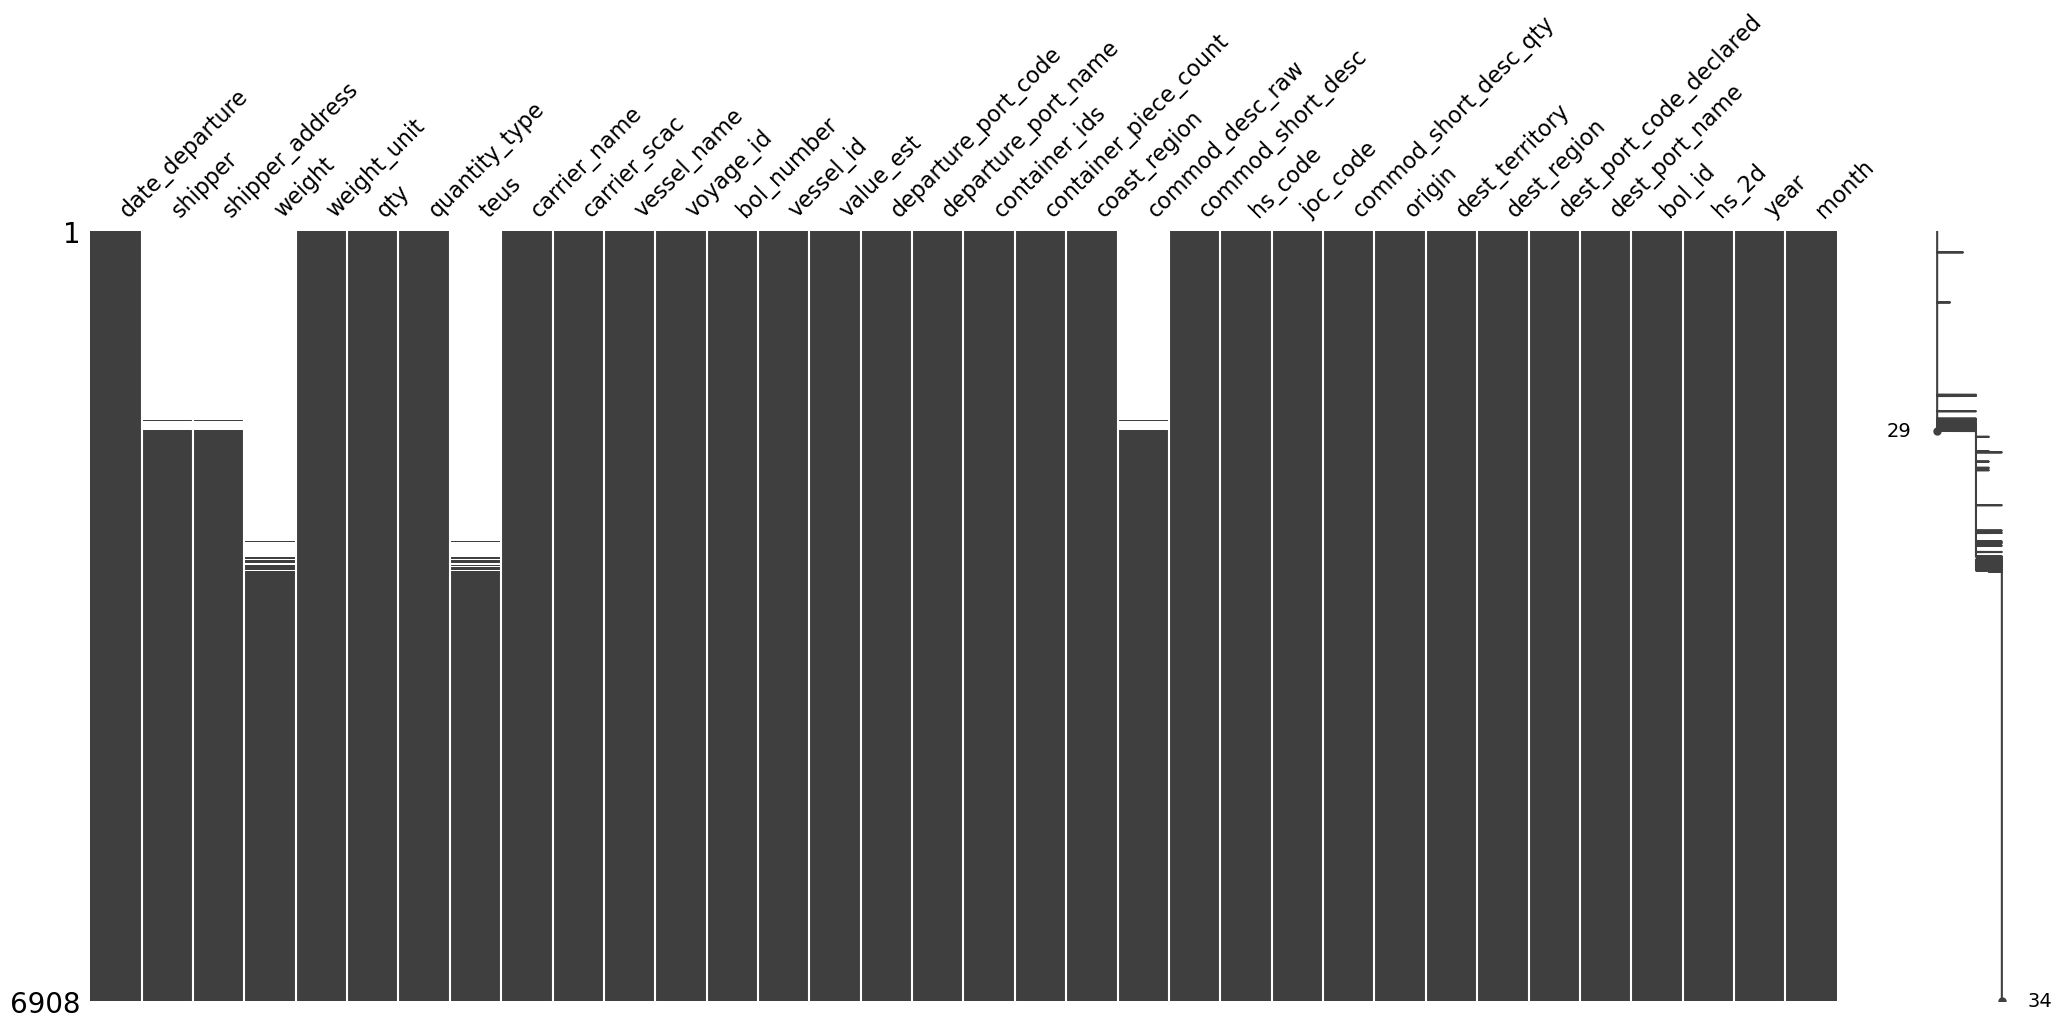

In [45]:
print('Missing Values Matrix for Exports. \nThe vertical axis corresponds to date, with earliest at the top.  \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    exports_lzdf
    .with_columns([
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_departure').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_departure').sum()
    .sort('date_departure')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

Missing Values Matrix for Imports. 
The vertical axis corresponds to date, with earliest at the top. 
Note the daily aggregation counts the row as non-null if any value that day is non-null.


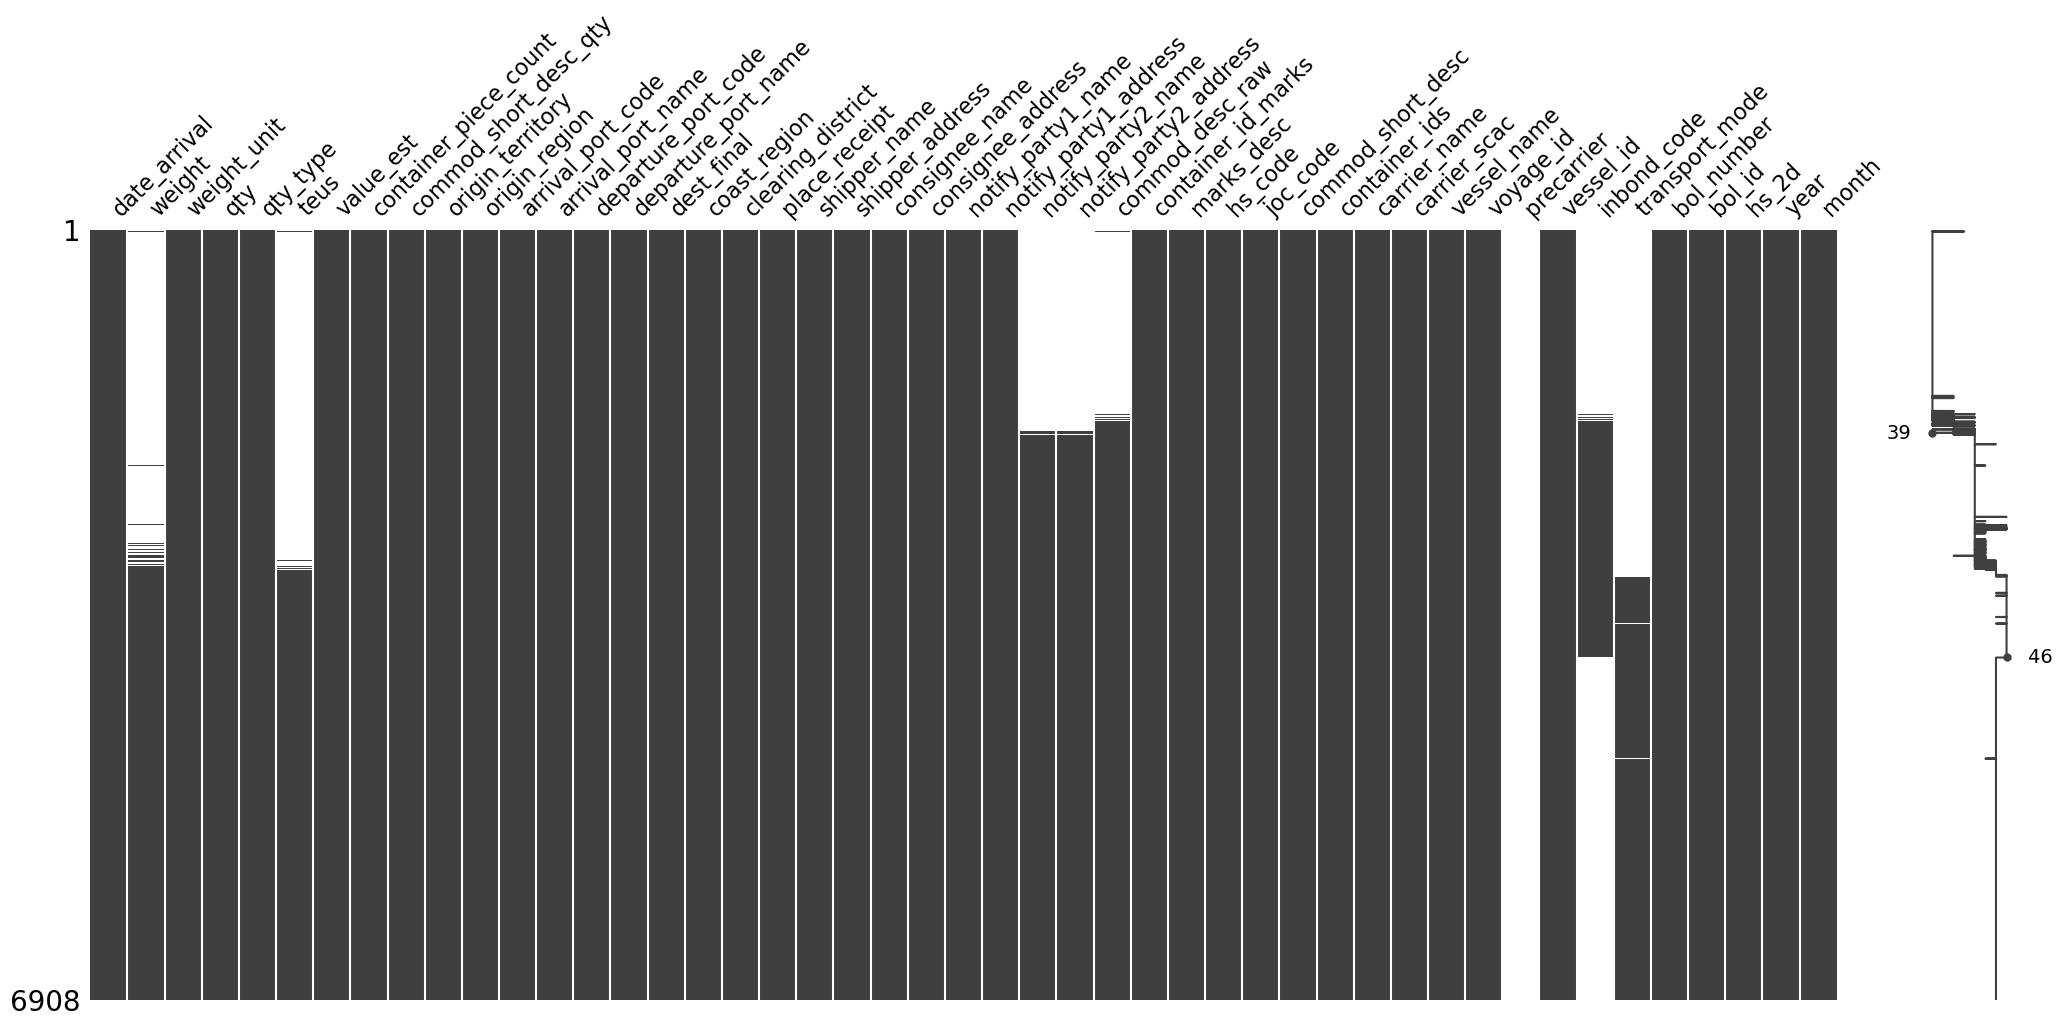

In [46]:
print('Missing Values Matrix for Imports. \nThe vertical axis corresponds to date, with earliest at the top. \nNote the daily aggregation counts the row as non-null if any value that day is non-null.')
msno.matrix(
    imports_lzdf
    .with_columns([
        #convert zero volume values to null
        pl.col('teus').replace(0,None),
        pl.col('weight').replace(0,None),
        pl.col('qty').replace(0,None)
        ])
    #convert all columns except date to boolean False=null
    .with_columns(pl.all().exclude('date_arrival').is_not_null())
    #aggregate by day to stay within visualization limitations 
    .group_by('date_arrival').sum()
    .sort('date_arrival')
    #convert False values back to null 
    .with_columns(pl.all().replace(0,None))
    .collect()
    .to_pandas()
    );

For the time being, we fill the zero (i.e., missing) volume data with the mean from non-zero observations. This step is expected to change as beter metadata is gathered. 

In [56]:
imports_lzdf = (
    imports_lzdf
    .with_columns([
        pl.col('teus').replace(0,None).fill_null(strategy='mean'),
        pl.col('weight').replace(0,None).fill_null(strategy='mean'),
        pl.col('qty').replace(0,None).fill_null(strategy='mean')
        ])
    )

exports_lzdf = (
    exports_lzdf
    .with_columns([
        pl.col('teus').replace(0,None).fill_null(strategy='mean'),
        pl.col('weight').replace(0,None).fill_null(strategy='mean'),
        pl.col('qty').replace(0,None).fill_null(strategy='mean')
        ])
    )

In [52]:
#Summary stats for Imports

#init df and get stats labels column
imports_summarystats_df = imports_lzdf.select(pl.first()).collect().describe().select(pl.first()).to_pandas()
#loop through columns and get descriptive stats
for column in imports_colnames:
    imports_summarystats_df[column] = imports_lzdf.select(pl.col(column)).collect().describe().select(column).to_pandas()
#display
print('Summary Stats - Imports')
imports_summarystats_df

Summary Stats - Imports


,describe,weight,weight_unit,qty,qty_type,teus,value_est,date_arrival,container_piece_count,commod_short_desc_qty,origin_territory,origin_region,arrival_port_code,arrival_port_name,departure_port_code,departure_port_name,dest_final,coast_region,clearing_district,place_receipt,shipper_name,shipper_address,consignee_name,consignee_address,notify_party1_name,notify_party1_address,notify_party2_name,notify_party2_address,commod_desc_raw,container_id_marks,marks_desc,hs_code,joc_code,commod_short_desc,container_ids,carrier_name,carrier_scac,vessel_name,voyage_id,precarrier,vessel_id,inbond_code,transport_mode,bol_number,bol_id
0,count,1.788759e+08,178875896,1.788759e+08,150054988,1.788759e+08,1.788759e+08,178875896,1.788759e+08,178875850,178004511,178004511,178842823,178842823,178399200,178399200,178875896,178767698,138267806,178028936,177152819,149352161,177316770,158522570,131500774,147349739,11190643,80229284,153344894,178875896,178875896,178875850,178875850,178875850,178875896,178743544,178875872,167484536,178875896,0.0,1.673943e+08,4.599980e+07,54698436,178875896,178875896
1,null_count,0.000000e+00,0,0.000000e+00,28820908,0.000000e+00,0.000000e+00,0,0.000000e+00,46,871385,871385,33073,33073,476696,476696,0,108198,40608090,846960,1723077,29523735,1559126,20353326,47375122,31526157,167685253,98646612,25531002,0,0,46,46,46,0,132352,24,11391360,0,178875896.0,1.148159e+07,1.328761e+08,124177460,0,0
2,mean,4.740686e+04,None,1.203557e+03,None,1.285770e+00,7.808732e+04,None,1.440886e+00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,9.338100e+06,3.066917e+02,None,None,None
3,std,1.721627e+06,None,4.090204e+05,None,3.112699e+00,2.853759e+06,None,3.409732e+00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,2.850288e+05,1.059749e+03,None,None,None
4,min,0.000000e+00,None,-7.456109e+07,None,0.000000e+00,0.000000e+00,2005-01-01 00:00:00,0.000000e+00,,None,None,None,None,None,None,None,None,None,None,,,,,,,& OPTCO,,,,,,,,,None,None,,,NaN,0.000000e+00,0.000000e+00,None,$70050200001,-1_CSHSE0009996
5,25%,0.000000e+00,None,1.000000e+00,None,0.000000e+00,0.000000e+00,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,9.248112e+06,0.000000e+00,None,None,None
6,50%,1.466000e+03,None,3.800000e+01,None,2.200000e-01,6.571000e+03,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,9.332884e+06,0.000000e+00,None,None,None
7,75%,1.501000e+04,None,4.000000e+02,None,2.000000e+00,4.552600e+04,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,9.462706e+06,0.000000e+00,None,None,None
8,max,6.172936e+09,None,3.531460e+09,None,1.730750e+03,9.981402e+09,2023-11-30 00:00:00,9.990000e+02,9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9...,None,None,None,None,None,None,None,None,None,None,“COOPERATIVA OPERAI CAVATORI DEL BOTTICINO,ÞORRASALIR 13,C MCCRACKEN,ŠILUTES STR 9,C MCCRACKEN,ŠILUTES STR 9,ZYP COATINGS,co RMI Titanium Company LLC 208, WORKING GLOVES,}No MarksNo MarksNo Marks,; ; ; ; ; ; ; ; ; ; ; ,ddedo,Y-,"ZIRCONIUM; SAND,FLOUR,SPONGE,POWDER VALVES; EN...",vTA1108,None,None,ZYGI,^144,NaN,9.975363e+06,7.122000e+03,None,_YLC158932,zimu_ZIMUZHJ0000952


In [55]:
#Summary stats for Exports

#NOTE at the moment the exports dataset may fit in memory, in which case the below code could be accomplished more efficiently
#by executing the following line; however, the main code below should run even when the dataset does not fit in memory. 
#exports_lzdf.collect().describe()

#init df and get stats labels column
exports_summarystats_df = exports_lzdf.select(pl.first()).collect().describe().select(pl.first()).to_pandas()
#loop through columns and get descriptive stats
for column in exports_colnames:
    exports_summarystats_df[column] = exports_lzdf.select(pl.col(column)).collect().describe().select(column).to_pandas()
#display
print('Summary Stats - Exports')
exports_summarystats_df

Summary Stats - Exports


,describe,shipper,shipper_address,weight,weight_unit,qty,quantity_type,teus,carrier_name,carrier_scac,vessel_name,voyage_id,bol_number,vessel_id,value_est,departure_port_code,departure_port_name,container_ids,container_piece_count,coast_region,commod_desc_raw,commod_short_desc,hs_code,joc_code,commod_short_desc_qty,date_departure,origin,dest_territory,dest_region,dest_port_code_declared,dest_port_name,bol_id
0,count,52901485,51534703,6.876949e+07,68769489,6.876949e+07,61810793,6.876949e+07,68595453,68768115,63384893,67625608,68769456,6.323115e+07,6.876949e+07,68720145,68720145,68769489,6.876949e+07,68769013,53168182,68769437,68769437,68769437,68769437,68769489,68769489,68279599,68279599,68299282,68299282,68769456
1,null_count,15868004,17234786,0.000000e+00,0,0.000000e+00,6958696,0.000000e+00,174036,1374,5384596,1143881,33,5.538337e+06,0.000000e+00,49344,49344,0,0.000000e+00,476,15601307,52,52,52,52,0,0,489890,489890,470207,470207,33
2,mean,None,None,1.152067e+05,None,3.965311e+04,None,1.672979e+00,None,None,None,None,None,9.159625e+06,1.415664e+05,None,None,None,1.923483e+00,None,None,None,None,None,None,None,None,None,None,None,None,None
3,std,None,None,2.375519e+06,None,3.471335e+06,None,5.518306e+00,None,None,None,None,None,5.438769e+05,6.466967e+06,None,None,None,1.109810e+01,None,None,None,None,None,None,None,None,None,None,None,None,None
4,min,,,0.000000e+00,None,-1.467123e+09,None,0.000000e+00,None,None,,,,1.960000e+02,0.000000e+00,None,None,,0.000000e+00,None,,,,,,2005-01-01 00:00:00,,None,None,None,None,079A_26004878070
5,25%,None,None,0.000000e+00,None,0.000000e+00,None,0.000000e+00,None,None,None,None,None,9.143568e+06,0.000000e+00,None,None,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None
6,50%,None,None,1.360800e+02,None,1.300000e+01,None,0.000000e+00,None,None,None,None,None,9.295220e+06,4.080000e+02,None,None,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None
7,75%,None,None,1.919696e+04,None,1.780000e+02,None,2.000000e+00,None,None,None,None,None,9.398424e+06,4.627100e+04,None,None,None,1.000000e+00,None,None,None,None,None,None,None,None,None,None,None,None,None
8,max,SUNSET TRANSPORTATION SERVICE,,9.529981e+08,None,3.716633e+09,None,3.729250e+03,None,None,xin yang shan,|SAL5,PE10518042,9.980629e+06,1.000000e+10,None,None,~POPLAR AVE |SAVALY762976 _38197 WFHU5153172 W...,4.136000e+03,None,ÙTEEL GUARD RAIL; ÙTEEL GUARD RAILS,"ZIRCONIUM; SAND,FLOUR,SPONGE,POWDER ZIRCONIUM ...",ddedo,9669000 7746000 1301000 6830000,9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9; 9...,2023-11-30 00:00:00,,None,None,None,None,zzzz_ZZZZ


In [57]:
#Counts of top imports categorical columns

#get categorical cols
imports_catcols_lzdf = (
    imports_lzdf.select(pl.col(pl.Categorical))
)
#init top cats df
imports_topcats_df = pl.DataFrame()

for colname in imports_catcols_lzdf.columns:
    col_counts_df = (
        #select column
        imports_catcols_lzdf.select(pl.col(colname))
        .collect()
        .to_series()
        #get top 10 value counts
        .value_counts()
        .sort('count', descending=True)
        .limit(10)
        #rename count column
        .rename({'count': colname + '_count'})
    )
    #stack dfs horizontally 
    imports_topcats_df = pl.concat([imports_topcats_df, col_counts_df], how='horizontal')

print('Counts of top 10 categories for each categorical variable in imports database:')
imports_topcats_df

Counts of top 10 categories for each categorical variable in imports database:


weight_unit,weight_unit_count,qty_type,qty_type_count,origin_territory,origin_territory_count,origin_region,origin_region_count,arrival_port_code,arrival_port_code_count,arrival_port_name,arrival_port_name_count,departure_port_code,departure_port_code_count,departure_port_name,departure_port_name_count,dest_final,dest_final_count,coast_region,coast_region_count,clearing_district,clearing_district_count,place_receipt,place_receipt_count,carrier_name,carrier_name_count,carrier_scac,carrier_scac_count,transport_mode,transport_mode_count
cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32
"""KG""",178875896,"""CTN""",50685096,"""CHINA (MAINLAN…",75748421,"""NORTH EAST ASI…",100044029,"""2704""",36437064,"""LOS ANGELES""",36437064,"""57035""",23761723,"""SHANGHAI""",23761723,""" """,178875896,"""WEST""",92073665,"""LOS ANGELES, C…",67153221,"""SHANGHAI""",23256000,"""MEDITERRANEAN …",17750989,"""MAEU""",13023524,null,124177460
null,null,"""CM""",33078826,"""VIETNAM""",7628769,"""SOUTH EAST ASI…",18718236,"""4601""",32461038,"""NEW YORK""",32461038,"""57078""",21377427,"""YANTIAN""",21377427,null,null,"""EAST""",74496467,null,40608090,"""YANTIAN""",19061963,"""MAERSK LINE""",15450322,"""EGLV""",12540853,"""MARITIME""",54698436
null,null,null,28820908,"""INDIA""",7420825,"""NORTH EUROPE""",18549213,"""2709""",30379775,"""LONG BEACH""",30379775,"""58023""",11126231,"""BUSAN""",11126231,null,null,"""GULF""",10576612,"""SAVANNAH, GEOR…",11073275,"""NINGBO""",8266716,"""EVERGREEN LINE…",13210626,"""CMDU""",11848743,null,null
null,null,"""PKG""",20376899,"""TAIWAN""",7093428,"""INDIAN SUB CON…",11088257,"""1703""",10870895,"""SAVANNAH""",10870895,"""57020""",10980717,"""HONG KONG""",10007635,null,null,"""CARIBBEAN""",1486746,"""SEATTLE, WASHI…",10626872,"""BUSAN""",5767191,"""CMA-CGM""",12767736,"""HLCU""",10899595,null,null
null,null,"""PCS""",15728895,"""GERMANY""",6640084,"""MEDITERRANEAN""",10919966,"""1401""",7834038,"""NORFOLK""",7834038,"""58201""",10007635,"""NINGBO""",8621898,null,null,"""GREAT LAKES""",134208,"""HOUSTON/GALVES…",7989565,"""QINGDAO""",5668080,"""HAPAG LLOYD""",12391309,"""COSU""",9183898,null,null
null,null,"""X""",11428859,"""REPUBLIC OF KO…",6393647,"""CENTRAL AMERIC…",5113232,"""5301""",7591326,"""HOUSTON""",7591326,"""58309""",8261696,"""KAOHSIUNG""",8261696,null,null,null,108198,"""NORFOLK, VIRGI…",7903877,"""HONG KONG""",5633841,"""CHINA OCEAN SH…",10347199,"""MEDU""",9068195,null,null
null,null,"""BXS""",3473802,"""HONG KONG""",5644361,"""WEST COAST SOU…",4142811,"""2811""",6626522,"""OAKLAND""",6626522,"""55976""",5882736,"""SINGAPORE""",5882736,null,null,null,null,"""MIAMI, FLORIDA…",7076741,"""HO CHI MINH""",4585227,"""ORIENT OVERSEA…",9546039,"""OOLU""",8323800,null,null
null,null,"""CS""",3347845,"""ITALY""",5447553,"""EAST COAST SOU…",3047243,"""0005""",6471974,"""VANCOUVER BC""",6471974,"""42870""",5008439,"""BREMERHAVEN""",5008439,null,null,null,null,"""SAN FRANCISCO,…",6665016,"""XIAMEN""",4164686,"""AMERICAN PRESI…",8122323,"""ONEY""",8070853,null,null
null,null,"""BGS""",1593183,"""JAPAN""",5163461,"""CARIBBEAN""",2718638,"""1601""",6468246,"""CHARLESTON""",6468246,"""57047""",4596130,"""QINGDAO""",4596130,null,null,null,null,"""CHARLESTON, S.…",6468460,"""KAOHSIUNG""",3066893,"""OCEAN NETWORK …",8069530,"""MSCU""",7268936,null,null


In [58]:
#Counts of top exports categorical columns

#get categorical cols
exports_catcols_lzdf = (
    exports_lzdf.select(pl.col(pl.Categorical))
)
#init top cats df
exports_topcats_df = pl.DataFrame()

for colname in exports_catcols_lzdf.columns:
    col_counts_df = (
        #select column
        exports_catcols_lzdf.select(pl.col(colname))
        .collect()
        .to_series()
        #get top 10 value counts
        .value_counts()
        .sort('count', descending=True)
        .limit(10)
        #rename count column
        .rename({'count': colname + '_count'})
    )
    #stack dfs horizontally 
    exports_topcats_df = pl.concat([exports_topcats_df, col_counts_df], how='horizontal')

print('Counts of top 10 categories for each categorical variable in exports database:')
exports_topcats_df

Counts of top 10 categories for each categorical variable in exports database:


weight_unit,weight_unit_count,quantity_type,quantity_type_count,carrier_name,carrier_name_count,carrier_scac,carrier_scac_count,departure_port_code,departure_port_code_count,departure_port_name,departure_port_name_count,coast_region,coast_region_count,dest_territory,dest_territory_count,dest_region,dest_region_count,dest_port_code_declared,dest_port_code_declared_count,dest_port_name,dest_port_name_count
cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32,cat,u32
"""KG""",68769489,"""CF""",20052121,"""MEDITERRANEAN …",5793495,"""HAPL""",4861095,"""4601""",9016653,"""NEW YORK""",9016653,"""EAST""",41638045,"""CHINA (MAINLAN…",5577757,"""NORTH EAST ASI…",17045863,"""90309""",3911195,"""SAN JUAN""",3911708
null,null,null,6958696,"""HAPAG LLOYD""",4861294,"""MLSL""",3539362,"""2704""",6071495,"""LOS ANGELES""",6071495,"""WEST""",18675268,"""PUERTO RICO""",3941260,"""CARIBBEAN""",13873527,"""58023""",2606295,"""BUSAN""",2606295
null,null,"""UNT""",6389123,"""MAERSK LINE""",4856652,"""MSCU""",3280334,"""5301""",5271211,"""HOUSTON""",5271206,"""GULF""",8002937,"""JAPAN""",3796480,"""NORTH EUROPE""",8987532,"""58201""",2430256,"""HONG KONG""",2430256
null,null,"""PCS""",6019382,"""CMA-CGM""",3296996,"""CMDU""",2930458,"""2709""",5249455,"""LONG BEACH""",5249455,"""CARIBBEAN""",436480,"""REPUBLIC OF KO…",3083205,"""CENTRAL AMERIC…",5586530,"""57035""",2193297,"""SHANGHAI""",2193297
null,null,"""PKG""",4463101,"""SEABOARD MARIN…",3223745,"""SMLU""",2575867,"""1803""",4646304,"""JACKSONVILLE""",4646304,"""GREAT LAKES""",16283,"""HONG KONG""",2430461,"""SOUTH EAST ASI…",3902742,"""42305""",2192089,"""ANTWERP""",2192089
null,null,"""CTN""",2784205,"""TROPICAL SHIPP…",2818095,"""MDSC""",2513240,"""5203""",4522768,"""PT EVERGLADES""",4522768,null,476,"""BELGIUM""",2306736,"""MEDITERRANEAN""",3486244,"""58309""",1658597,"""KAOHSIUNG""",1658597
null,null,"""PLT""",2730319,"""ORIENT OVERSEA…",2720267,"""TRSL""",2308826,"""1703""",4481005,"""SAVANNAH""",4481005,null,null,"""BAHAMAS""",2299915,"""AFRICA""",3342850,"""42157""",1619013,"""ROTTERDAM""",1619013
null,null,"""CS""",2713884,"""CROWLEY LINER …",2705052,"""CAMN""",2102643,"""5201""",4120195,"""MIAMI""",4120195,null,null,"""TAIWAN""",2156880,"""WEST COAST SOU…",2615873,"""42870""",1433094,"""BREMERHAVEN""",1433094
null,null,"""CM""",2504807,"""EVERGREEN LINE…",2316248,"""EGLV""",2093878,"""1401""",4083423,"""NORFOLK""",4083423,null,null,"""GERMANY""",2073918,"""EAST COAST SOU…",2601738,"""58886""",1408627,"""TOKYO""",1408627


## Exploratory Stats and Visuals

This section presents basic comparisons between variables and other exploratory analysis. See the [discussion below regarding known issues with the dataset](#known-data-issues)

In [59]:
def count2w(data_lzdf, groupby_colname, counts_colnames, normalize=False, reference_colname=False, limit=50):
    '''
    Creates a dataframe showing two-way counts of the variables passed. 
    INPUT:
        data_lzdf - a polars lazyframe containing the relevant data
        groupby_colname - the column name to group by
        counts_colnames - a list of column names
        normalize - boolean - default=False - when True, values in the dataframe will be divided row-wise by the reference column.
        reference_colname - the reference column. The resultant dataframe will be sorted (descending) by this column.
                    note: reference_colname must appear in the counts_colnames list, and must be specified when normalize=True.
    OUTPUT:
        count2w_df - a polars dataframe with the normalized two-way counts for each variable
    Depends on:
        polars
    '''
    counts2w_df = (
        data_lzdf
        .group_by(groupby_colname)
        .agg([
            pl.col(col).count() for col in counts_colnames
        ])
        .sort(groupby_colname if not reference_colname else reference_colname, descending=True)
        .limit(limit)
        #normalize by reference column if normalize = True
        .select([groupby_colname, *counts_colnames] if not normalize else [pl.col(groupby_colname)]+[pl.col(col)/pl.col(reference_colname) for col in counts_colnames])
        .collect()
    )
    return counts2w_df

In [60]:
count2w(
    data_lzdf = imports_lzdf.with_columns(pl.col('teus').replace(0, None)), 
    groupby_colname= 'year',
    counts_colnames= ['arrival_port_name', 'teus', 'container_piece_count', 'origin_territory', 'hs_code', 'carrier_scac', 'bol_id'],
    normalize=True, 
    reference_colname= 'bol_id'
).sort('year', descending=True)

year,arrival_port_name,teus,container_piece_count,origin_territory,hs_code,carrier_scac,bol_id
i32,f64,f64,f64,f64,f64,f64,f64
2023,1.0,1.0,1.0,0.999845,0.999999,1.0,1.0
2022,1.0,1.0,1.0,0.999858,0.999999,1.0,1.0
2021,1.0,1.0,1.0,0.999897,0.999999,1.0,1.0
2020,0.999883,1.0,1.0,0.999861,1.0,1.0,1.0
2019,0.999997,1.0,1.0,0.9997,1.0,1.0,1.0
2018,0.999982,1.0,1.0,0.999791,1.0,1.0,1.0
2017,0.999978,1.0,1.0,0.999731,1.0,0.999998,1.0
2016,0.999996,1.0,1.0,0.999787,1.0,1.0,1.0
2015,0.999996,1.0,1.0,0.999791,1.0,1.0,1.0


In [61]:
count2w(
    data_lzdf = (
        imports_lzdf.with_columns([
            #create week column
            pl.col('date_arrival').dt.week().alias('week'),
            #replace 0 values with null
            pl.col('teus').replace(0,None)
            ])
    ),
    groupby_colname= 'week',
    counts_colnames= ['arrival_port_name', 'teus', 'container_piece_count', 'origin_territory', 'hs_code', 'carrier_scac', 'bol_id'],
    reference_colname= 'bol_id',
    normalize=True
).sort('week')

week,arrival_port_name,teus,container_piece_count,origin_territory,hs_code,carrier_scac,bol_id
i8,f64,f64,f64,f64,f64,f64,f64
1,0.999681,1.0,1.0,0.994864,1.0,1.0,1.0
2,0.999718,1.0,1.0,0.994513,1.0,1.0,1.0
3,0.999733,1.0,1.0,0.994769,0.999999,1.0,1.0
4,0.999761,1.0,1.0,0.994739,1.0,1.0,1.0
5,0.999767,1.0,1.0,0.994357,1.0,1.0,1.0
6,0.999771,1.0,1.0,0.994132,1.0,1.0,1.0
7,0.999795,1.0,1.0,0.995192,1.0,1.0,1.0
8,0.999694,1.0,1.0,0.995355,1.0,1.0,1.0
9,0.999755,1.0,1.0,0.995235,0.999999,1.0,1.0


In [62]:
count2w(imports_lzdf, 
        groupby_colname='arrival_port_name', 
        counts_colnames=['teus', 'container_piece_count', 'origin_territory', 'hs_code', 'carrier_scac', 'bol_id'], 
        normalize=True,
        reference_colname='bol_id', 
        limit=50)

arrival_port_name,teus,container_piece_count,origin_territory,hs_code,carrier_scac,bol_id
cat,f64,f64,f64,f64,f64,f64
"""LOS ANGELES""",1.0,1.0,0.994696,1.0,0.999999,1.0
"""NEW YORK""",1.0,1.0,0.996438,1.0,1.0,1.0
"""LONG BEACH""",1.0,1.0,0.99438,1.0,1.0,1.0
"""SAVANNAH""",1.0,1.0,0.995334,1.0,1.0,1.0
"""NORFOLK""",1.0,1.0,0.995169,1.0,1.0,1.0
"""HOUSTON""",1.0,1.0,0.997686,0.999999,1.0,1.0
"""OAKLAND""",1.0,1.0,0.995726,1.0,1.0,1.0
"""VANCOUVER BC""",1.0,1.0,0.991612,1.0,1.0,1.0
"""CHARLESTON""",1.0,1.0,0.997309,1.0,1.0,1.0


In [63]:
def groupby_summarystats(data_lzdf, group_var, stats_vars, sort_var=False, limit=100):
    '''
    Calculates summary stats of each variable of interest for each group in a polars lazyframe. 
    INPUT:
        data_lzdf - Polars LazyFrame - lazyframe containing the relevant data
        group_var - Str - the name of the column to group by
        stats_vars - List - the names of the columns of interest
        sort_var - Str - default=False - when False, the resultant dataframe will be sorted by the
                                        group_by variable. Note that polars categories can have unexpected
                                        ordernal values. 
                                        when True, sorts the resultant dataframe by the sum of
                                        the named variable. Note sort_var must be an element of
                                        stats_vars. 
        limit - UInt - default=100 - limits the number of rows in the resultant dataframe. 
    OUTPUT:
        groupby_summarystats_df - Polars DataFrame - a dataframe containing the summary stats for each group
    '''
    agg_list = []
    for var in stats_vars:
        agg_list.append(pl.col(var).sum().alias(var+'_sum'))
        agg_list.append(pl.col(var).mean().alias(var+'_mean'))
        agg_list.append(pl.col(var).median().alias(var+'_median'))
        agg_list.append(pl.col(var).std().alias(var+'_std'))
    groupby_summarystats_df = (
        data_lzdf.group_by(group_var)
        .agg(agg_list)
        .sort(group_var if not sort_var else sort_var+'_sum', descending=True)
        .limit(limit)
        .collect()
    )
    return groupby_summarystats_df

In [64]:
for var in ['arrival_port_name', 'hs_2d', 'origin_territory', 'carrier_scac']:
    display(
        groupby_summarystats(imports_lzdf, group_var=var, stats_vars=['teus', 'qty', 'weight'], sort_var='teus', limit=20),
    )

arrival_port_name,teus_sum,teus_mean,teus_median,teus_std,qty_sum,qty_mean,qty_median,qty_std,weight_sum,weight_mean,weight_median,weight_std
cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""LOS ANGELES""",7.7626e7,2.130417,2.196793,2.692905,4.5879e10,1259.14187,302.0,99227.826543,1.5922e12,43697.384065,23798.0,470665.150719
"""LONG BEACH""",6.6365e7,2.18451,2.196793,2.615647,3.8831e10,1278.200817,321.0,407137.611614,1.5003e12,49383.297752,25099.0,921176.736299
"""NEW YORK""",6.2598e7,1.92841,2.0,2.161371,5.1804e10,1595.884723,394.0,743413.39849,1.7326e12,53373.403374,24499.0,832345.17063
"""SAVANNAH""",2.6791e7,2.46446,2.0,3.363662,1.3868e10,1275.656972,353.0,73144.510186,4.9081e11,45148.689962,20200.0,1.9131e6
"""NORFOLK""",1.8002e7,2.297912,2.0,2.906493,1.5986e10,2040.598863,281.0,269902.154173,3.4067e11,43486.009245,23657.005,247845.618508
"""HOUSTON""",1.7481e7,2.302758,2.0,3.096366,1.2100e10,1593.912693,261.0,225377.155037,9.5334e11,125582.303359,24608.0,2.5029e6
"""OAKLAND""",1.5578e7,2.35085,2.196793,2.733595,9.8243e9,1482.578535,274.0,108615.481075,2.9157e11,43999.933176,33035.0,94294.98401
"""CHARLESTON""",1.5235e7,2.355285,2.0,3.505581,8.5328e9,1319.176899,150.0,97805.594346,3.4982e11,54082.625504,30300.0,737069.346904
"""VANCOUVER BC""",1.4369e7,2.220265,2.196793,3.255396,8.2714e9,1278.036328,273.0,136418.522826,3.5679e11,55128.911292,76862.448175,755909.777587


hs_2d,teus_sum,teus_mean,teus_median,teus_std,qty_sum,qty_mean,qty_median,qty_std,weight_sum,weight_mean,weight_median,weight_std
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""94""",4.3402e7,2.504242,2.0,2.651121,1.5664e10,903.809319,270.0,105979.654654,6.3525e11,36652.639771,18207.95658,129236.291924
"""84""",3.2559e7,2.197275,2.196793,2.9915,1.3349e10,900.862688,84.0,80961.591411,6.3159e11,42623.840803,22670.10746,426268.556632
"""85""",2.3451e7,2.261463,2.196793,3.285962,1.5390e10,1484.130437,264.0,143281.712892,4.4062e11,42489.652775,26984.5488,89386.558612
"""39""",2.2323e7,2.243372,2.0,2.616155,1.7069e10,1715.358093,477.0,124773.919909,4.1849e11,42056.598306,23060.0,221048.973398
"""87""",2.1164e7,2.326991,2.196793,3.88314,1.3956e10,1534.450878,94.0,55341.26971,4.9000e11,53876.290131,34400.0,204008.917354
"""95""",1.7774e7,2.144907,2.196793,2.577411,1.1165e10,1347.325383,381.0,161039.205422,2.8950e11,34935.956805,13320.31404,144087.100966
"""73""",1.5507e7,2.079571,2.196793,2.350266,8.3434e9,1118.914803,232.0,75474.409615,4.4324e11,59442.182415,40785.47,871031.92388
"""62""",1.4759e7,1.608722,2.196793,1.436466,1.1021e10,1201.249325,245.0,297467.331943,3.4561e11,37670.723813,17499.0,65789.439636
"""00""",1.3348e7,1.967846,2.196793,2.12065,9.2559e9,1364.529267,900.0,96393.323685,4.6929e11,69183.738025,76862.448175,1.0489e6


origin_territory,teus_sum,teus_mean,teus_median,teus_std,qty_sum,qty_mean,qty_median,qty_std,weight_sum,weight_mean,weight_median,weight_std
cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""CHINA (MAINLAN…",1.6821e8,2.220592,2.196793,2.537456,8.3504e10,1102.384248,375.0,282567.228204,3.0600e12,40397.470943,21490.0,228921.358513
"""VIETNAM""",1.8244e7,2.391511,2.0,3.213495,7.4178e9,972.350018,245.0,40593.860818,2.4044e11,31517.767414,13040.3273,268399.91402
"""REPUBLIC OF KO…",1.5096e7,2.361146,2.196793,3.349785,6.4760e9,1012.876754,85.0,102109.388738,4.6863e11,73296.010423,48151.95,969653.775135
"""GERMANY""",1.3699e7,2.063024,2.0,3.208172,1.0332e10,1555.952191,67.0,81030.227925,3.1752e11,47818.157592,22841.0,313146.79402
"""TAIWAN""",1.3437e7,1.894263,2.196793,2.034658,1.0369e10,1461.753678,322.0,69388.914515,3.3829e11,47691.203046,39852.91574,604511.515448
"""INDIA""",1.2813e7,1.726584,2.0,1.618322,9.8952e9,1333.437568,126.0,228421.954938,3.4288e11,46204.777589,20548.0,697041.606137
"""JAPAN""",1.2358e7,2.393412,2.196793,3.943496,1.3856e10,2683.491201,76.0,71927.867284,3.6997e11,71650.833448,76862.448175,685702.060475
"""ITALY""",1.0180e7,1.868736,2.0,2.109359,9.3543e9,1717.161042,1098.0,872032.985002,2.7502e11,50485.717874,37628.45416,606584.624991
"""HONG KONG""",9.9992e6,1.77154,2.196793,1.433018,5.5757e9,987.843715,290.0,83467.517042,2.8328e11,50188.39233,76862.448175,44026.469983


carrier_scac,teus_sum,teus_mean,teus_median,teus_std,qty_sum,qty_mean,qty_median,qty_std,weight_sum,weight_mean,weight_median,weight_std
cat,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""MAEU""",2.9509e7,2.265818,2.0,3.220517,1.7185e10,1319.514563,127.0,159235.481839,4.8842e11,37503.242872,19175.78476,52456.238049
"""EGLV""",2.7915e7,2.225917,2.0,2.971149,1.5104e10,1204.369733,196.0,109925.837996,4.6928e11,37420.306433,19180.0,44554.450605
"""CMDU""",2.6536e7,2.239584,2.0,3.417202,1.3105e10,1106.0341,432.0,16549.115847,3.8259e11,32289.70114,16356.0,53463.365906
"""HLCU""",2.3806e7,2.184125,2.0,3.001587,1.4757e10,1353.892046,1068.0,156236.542429,3.9781e11,36497.239251,19293.0,53752.765282
"""MEDU""",2.1954e7,2.420943,2.0,3.649505,1.2446e10,1372.540118,313.0,85969.339855,1.8787e11,20717.414013,14178.0,39361.767974
"""COSU""",2.0460e7,2.227817,2.0,3.387346,1.0946e10,1191.821201,240.0,720320.070351,2.8164e11,30666.999425,14600.0,40889.223909
"""MSCU""",1.7320e7,2.382787,2.196793,3.391186,6.6892e9,920.245806,704.0,45886.625186,4.4145e11,60731.00312,76862.448175,77020.256384
"""OOLU""",1.6880e7,2.027969,2.0,2.343099,1.0158e10,1220.404828,410.0,103874.427376,2.4760e11,29746.264433,13552.0,37284.10582
"""ONEY""",1.5479e7,1.917836,1.75,3.446204,8.7161e9,1079.951164,151.0,19300.315864,9.8569e10,12212.965383,5872.0,25472.217944


In [65]:
def groupsum(data_lzdf, groupby_colname, sum_colnames, reference_colname=False, limit=20):
    '''
    Creates a dataframe showing sums of the variables passed by group. 
    INPUT:
        data_lzdf - a polars lazyframe containing the relevant data
        groupby_colname - the column name to group by
        sum_colnames - a list of column names
        normalize - boolean - default=False - when True, values in the dataframe will be divided row-wise by the reference column.
        reference_colname - the reference column. The resultant dataframe will be sorted (descending) by this column.
                    note: reference_colname must appear in the counts_colnames list, and must be specified when normalize=True.
    OUTPUT:
        count2w_df - a polars dataframe with the normalized two-way counts for each variable
    Depends on:
        polars
    '''
    groupsum_df = (
        data_lzdf
        .group_by(groupby_colname)
        .agg([
            pl.col(col).sum() for col in sum_colnames
        ])
        .sort(groupby_colname if not reference_colname else reference_colname, descending=True)
        .limit(limit)
        .collect()
    )
    return groupsum_df

In [66]:
def box_sums_by_time(data_lzdf, value_var, group_var, time_var, limit=10, title=''):
    '''
    Plots box and whisker diagram of the sums of the given variable for each group over time. 
    INPUT:
        data_lzdf - polars lazyframe - the relevant data
        value_var - str - the column name containing the variable of interest
        group_var - str - the column name by which the data will be grouped
        time_var - str - the column name containing the time category
        limit - int - default=10 - limits the number of categories presented
        title - str - the title of the box and whisker diagram. 
    OUTPUT:
        Displays the figure
    NOTES:
        - resulting figure is sorted by median value for each category
    DEPENDS ON:
        polars, plotly express 
    '''
    top_cats = (
        data_lzdf.select([group_var, value_var])
        .group_by(group_var)
        .agg(pl.col(value_var).sum())
        .sort(value_var, descending=True)
        .limit(limit)
        .collect()
    ).select(group_var).to_series().to_list()
    box_df = (
        data_lzdf.select([value_var, group_var, time_var])
        .filter(pl.col(group_var).is_in(top_cats))
        .group_by(time_var, group_var)
        .agg(pl.col(value_var).sum())
        .collect()
    )
    #get median values for ordering
    medians = (
        box_df.group_by(group_var)
        .agg(pl.col(value_var).median())
        .sort(value_var)
    ).to_series().to_list()
    fig = px.box(
            data_frame=box_df,
            y=group_var,
            x=value_var,
            title=title
        )
    fig.update_yaxes(categoryorder='array', categoryarray=medians)
    return fig

In [67]:
def box_counts_by_time(data_lzdf, value_var, group_var, time_var, limit=10, title=''):
    '''
    Plots box and whisker diagram of the counts of the given variable for each group over time. 
    INPUT:
        data_lzdf - polars lazyframe - the relevant data
        value_var - str - the column name containing the variable of interest
        group_var - str - the column name by which the data will be grouped
        time_var - str - the column name containing the time category
        limit - int - default=10 - limits the number of categories presented
        title - str - the title of the box and whisker diagram. 
    OUTPUT:
        Displays the figure
    NOTES:
        - resulting figure is sorted by median value for each category
    DEPENDS ON:
        polars, plotly express 
    '''
    #get top categories
    top_cats = (
        data_lzdf.select([group_var, value_var])
        .group_by(group_var)
        .agg(pl.col(value_var).count())
        .sort(value_var, descending=True)
        .limit(limit)
        .collect()
    ).select(group_var).to_series().to_list()
    #make df for box plots
    box_df = (
        data_lzdf.select([value_var, group_var, time_var])
        .filter(pl.col(group_var).is_in(top_cats))
        .group_by(time_var, group_var)
        .agg(pl.col(value_var).count())
        .cast({value_var: pl.Int32})
        .collect()
    )
    #get median values for ordering - only necessary because plotly's categoryorder='median ascending' does not act as expected 
    medians = (
        box_df.group_by(group_var)
        .agg(pl.col(value_var).median())
        .sort(value_var)
    ).to_series().to_list()
    fig = px.box(
            data_frame=box_df,
            y=group_var,
            x=value_var,
            title=title
        )
    fig.update_yaxes(categoryorder='array', categoryarray=medians)
    fig.show()

In [68]:
box_sums_by_time(
    data_lzdf=imports_lzdf,
    value_var='teus',
    group_var='hs_2d',
    time_var='month',
    title='TEUs Imported per Month by HS Code'
).show()

In [69]:
box_sums_by_time(
    data_lzdf=exports_lzdf,
    value_var='teus',
    group_var='hs_2d',
    time_var='month',
    title='TEUs Exported per Month by HS Code'
).show()

In [70]:
box_counts_by_time(
    data_lzdf=imports_lzdf,
    value_var='vessel_id',
    group_var='arrival_port_name',
    time_var='month',
    limit=15,
    title='Number of Vessels Arriving per Month by Port'
)

In [71]:
def volumes_over_time_plotly(data_lzdf, time_var, group_var, volume_var, title=''):
    volume_df = (
        data_lzdf.select([time_var, group_var, volume_var])
        .group_by(time_var, group_var)
        .sum()
        .sort(time_var)
        .collect()
    )
    fig = px.line(
        data_frame=volume_df,
        x=time_var, y=volume_var,
        color=group_var,
        title=title
    )
    fig.show()

In [72]:
volumes_over_time_plotly(
    imports_lzdf.with_columns(pl.col('teus').replace(0,2)), 
    time_var='year', 
    group_var='arrival_port_name', 
    volume_var='teus', 
    title='Total TEUs imported by arrival port')

/Users/adamwilson/miniconda3/envs/wsu/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [73]:
volumes_over_time_plotly(exports_lzdf, 'year', 'departure_port_name', 'teus', title='Total TEUs exported by port.')

/Users/adamwilson/miniconda3/envs/wsu/lib/python3.12/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [74]:
volumes_over_time_plotly(imports_lzdf.with_columns(pl.col('date_arrival').dt.week().alias('week')), 'week', 'hs_2d', 'teus', title='Weekly Volume (TEU) Imported by HS Code')

## Known Data Issues

The below cells inspect known, unresolved issues in the database such as duplicated Bills of Lading, inconsistent carrier names/codes, etc. 

Known issues to be resolved:
- duplicate bols
- missing weight and teu data pre2015
- carrier names
- quantity types are quite varied 


### Duplicate BOLs 

In [ ]:
#count unique bol_scac IDs
import_bols_unique_n = imports_lzdf.select(pl.col('bol_id')).unique().select(pl.count()).collect().item()
export_bols_unique_n = exports_lzdf.select(pl.col('bol_id')).unique().select(pl.count()).collect().item()

print('{:,} out of {:,} rows ({:.2f}%) in the imports dataset contain duplicated BoLs.'.format(imports_n-import_bols_unique_n, imports_n, (imports_n-import_bols_unique_n)/imports_n*100))
print('{:,} out of {:,} rows ({:.2f}%) in the exports dataset contain duplicated BoLs.'.format(exports_n-export_bols_unique_n, exports_n, (exports_n-export_bols_unique_n)/exports_n*100))

1,158,525 out of 178,875,896 rows (0.65%) in the imports dataset contain duplicated BoLs.
3,488,195 out of 68,769,489 rows (5.07%) in the exports dataset contain duplicated BoLs.


In [ ]:
dup_importbols_lzdf = (
    imports_lzdf.filter(pl.col('bol_id').is_duplicated())
    .select(['year', 'bol_id'])
    .group_by('year')
    .agg(pl.col('bol_id').count().alias('bols'))
    .sort('year')
    .with_columns(pl.lit('import').alias('direction'))
    )

dup_exportbols_lzdf = (
    exports_lzdf.filter(pl.col('bol_id').is_duplicated())
    .select(['year', 'bol_id'])
    .group_by('year')
    .agg(pl.col('bol_id').count().alias('bols'))
    .sort('year')
    .with_columns(pl.lit('export').alias('direction'))
    )

dup_bols_df = dup_importbols_lzdf.merge_sorted(dup_exportbols_lzdf, key='year').collect()

In [ ]:
dup_bols_df.head()

year,bols,direction
i32,u32,str
2005,322098,"""import"""
2005,835787,"""export"""
2006,327911,"""import"""
2006,861796,"""export"""
2007,76927,"""import"""


In [ ]:
def counts_over_time_plotly(data_lzdfs, lzdfs_aliases, time_var, value_var, title=False):
    #init lzdf
    lzdf = pl.LazyFrame(schema={time_var:pl.Int32, 'count':pl.Int32, 'source':pl.Utf8})
    #groupby and concat
    for i, frame in enumerate(data_lzdfs):
        frame_lzdf = (
            frame.select([time_var, value_var])
            .group_by(time_var)
            .agg(pl.col(value_var).count().alias('count'))
            .sort(time_var)
            .with_columns(pl.lit(lzdfs_aliases[i]).alias('source'))
        )
        lzdf = pl.concat([lzdf,frame_lzdf], how='vertical_relaxed')
    #plot
    fig = px.line(
        data_frame=lzdf.collect(),
        x=time_var, y='count',
        color='source',
        title= 'Count of Observations over time by source frame.' if not title else title
    )
    fig.show()

In [ ]:
shared_voyages_df = (
    imports_lzdf
    .with_columns([
        #combine vessel name and voyage number into sailing_id
        (pl.col('vessel_name').cast(pl.Utf8)+pl.col('voyage_id')).alias('sailing_id'),
        #create month-year variable
        pl.col('date_arrival').dt.strftime('%Y%m').alias('month')
        ])
    #select relevant columns
    .select(['month', 'sailing_id', 'carrier_scac'])
    #group by month and sailing
    .group_by('month', 'sailing_id')
    #count unique carriers represented on each individual sailing
    .agg(pl.col('carrier_scac').n_unique())
    #group by month, counting unique sailings and summing the number of carriers for each
    .group_by('month')
    .agg([
        pl.col('sailing_id').n_unique(),
        pl.col('carrier_scac').sum()
    ])
    #create average number of SCAC codes present on each sailing for the month
    .with_columns((pl.col('carrier_scac')/pl.col('sailing_id')).alias('scacs_per_voyage_avg'))
    .sort('month')
    .collect()
)

In [ ]:
px.line(
    data_frame=shared_voyages_df,
    x='month', y='scacs_per_voyage_avg',
    title='Average Number of Unique Carriers per voyage over time (Imports)'
)

In [ ]:
#inspect number of unique sailing_ids in imports database
imports_lzdf.with_columns((pl.col('vessel_name').cast(pl.Utf8)+pl.col('voyage_id')).alias('sailing_id')).select('sailing_id').collect().n_unique()

1433123

All in all - the data is still much messier than we need it to be. For example, it's hard to imagine why the average number of carriers per vessel spiked in April 2012. 

Next up: plot proportion of bols that sailed on shared vessels over time. 

In [ ]:
counts_over_time_plotly(
    data_lzdfs=[imports_lzdf, exports_lzdf],
    lzdfs_aliases=['imports', 'exports'],
    time_var='year',
    value_var='bol_id',
    title='Count of BOLs over time.'
)

In [ ]:
counts_over_time_plotly(data_lzdfs=[imports_lzdf.filter(pl.col('bol_id').is_duplicated()), 
                                    exports_lzdf.filter(pl.col('bol_id').is_duplicated())], 
                                    lzdfs_aliases=['imports', 'exports'], 
                                    time_var='year', 
                                    value_var='bol_id',
                                    title='Duplicated BOLs over time by direction.')

Possible reasons:
- data entry errors
- aggregations of some kind by S&P
- ???

### Missing weight and TEU data 

- weight data is inconsisent prior to 2017
    - inexplicably spiking 2015-2017 
    - inexplicably low 2013-2014
    - entirely missing prior to 2013

- TEU data is similarly strange
    - large jump 2021-2022
    - inexplicably low 2013-2014
    - entirely missing prior to 2013

We are pursuing this with S&P

### Carrier Names 

In [ ]:
carriers_df = (imports_lzdf.select([pl.col('carrier_scac'), 
                                    pl.col('carrier_name')])
               .unique() 
               .sort('carrier_scac', descending=True)
               .collect()
               )

scac_unique = (
    imports_lzdf.select(pl.col('carrier_scac'))
    .unique()
    .cast(pl.Utf8)
    .sort('carrier_scac')
    .collect()
)
#scac_unique.write_csv('scac_unique.csv')

In [ ]:
carriers_df.describe()

describe,carrier_scac,carrier_name
str,str,str
"""count""","""4383""","""3993"""
"""null_count""","""1""","""391"""
"""mean""",null,null
"""std""",null,null
"""min""",null,null
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""",null,null


In [ ]:
dupscacs_df = (
    carriers_df.drop_nulls(subset='carrier_name')
    .filter(pl.col('carrier_scac').is_duplicated())
)

dupnames_df = (
    carriers_df.drop_nulls(subset='carrier_scac')
    .filter(pl.col('carrier_name').is_duplicated())
    .sort('carrier_name')
)

Discussion:
- There appear to be very few (~200 out of 178M) duplications of SCAC codes based on different spelling or naming of carriers.
- SCAC codes that need to be addressed:
    - 'BULK' (~50 rows)
    - '-1' (1 row)
    - 'ZZZZ' (a carrier scac corresponding to entirely missing carrier name data in this database)
    - these could be coded as null values in the ETL step

# Older code - likely to be dropped

## Value and Volumes by Year:

In [ ]:
#get year col
pldf['year'] = pldf.date_arrival.dt.to_period('Y')
#group value and volume by year
activityacrosstime_df = pldf[['year', 'teus', 'value_est']].groupby('year').sum()
#plot
sns.barplot(data=activityacrosstime_df, x='year', y='value_est');
plt.title('Total Value of Imports Over Time')
plt.xticks(rotation=45);

In [ ]:
#plot
sns.barplot(data=activityacrosstime_df, x='year', y='teus');
plt.title('Total Volume (TEUs) of Imports Over Time')
plt.xticks(rotation=45);

I guess value and volume records weren't kept before ~2015 ?!?

In [ ]:
#group value and volume by year
until2012_df = pldf[pldf['year']< pd.Period(2013)]
until2012_df = until2012_df[['year', 'teus', 'value_est']].groupby('year').sum()
#plot
sns.barplot(data=until2012_df, x='year', y='teus');
plt.title('Total Volume (TEUs) of Imports Over Time')
plt.xticks(rotation=45);

Must be missing data here?

In [ ]:
#get year col
pldf['year'] = pldf.date_arrival.dt.to_period('Y')
#group value and volume by year
activityacrosstime_df = pldf[['year', 'container_piece_count']].groupby('year').sum()
#plot
sns.barplot(data=activityacrosstime_df, x='year', y='container_piece_count');
plt.title('Total Volume (Container Piece Count) of Imports Over Time')
plt.xticks(rotation=45);

In [ ]:
pldf.head()

## Carriers Over Time

In [ ]:
carriersovertime_df = pldf[['year', 'carrier_scac']].groupby('year').nunique()

In [ ]:
sns.barplot(data=carriersovertime_df, x='year', y='carrier_scac');
plt.title('Number of Unique Carriers Over Time');
plt.xticks(rotation=45);

Was there really a spike in carriers in 2010 and 2012? Or does this indicate changes in the way SCAC codes are assigned?

### Market share of the 50 largest carriers by estimated value 

In [ ]:
#get largest carriers
carriers_df = pldf[pldf.year > pd.Period(2014)]
carriers_df = carriers_df[['year', 'carrier_scac', 'value_est']].groupby(['year', 'carrier_scac']).sum()

In [ ]:
carriers_df.columns = ['value_usd']
carriers_df.sort_values('value_usd', ascending=False, inplace=True)
carriers_df.sort_values('year', inplace=True)

In [ ]:
carriers_df.reset_index(inplace=True)
carriers_df.head()